# Master equation model of the alanine pentapeptide

In this example we deal with a simple but realistic example of MD simulation data, generated with the [Gromacs package](http://www.gromacs.org/).
First we import a number of general purpose Python libraries we will need as we run this example.

In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.2)
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})

Next, we download the relevant data from the following [location](https://osf.io/a2vc7/) 

In [2]:
from mastermsm.test.download_data import download_osf_ala5

In [3]:
try:
    os.mkdir("test")
    download_osf_ala5()
except FileExistsError:
    pass

### Discretizing the trajectory
We start loading the data using the data structures from the `trajectory` module. For this we use the external library [`MDtraj`](http://mdtraj.org), which contains all sorts of interesting methods for parsing and calculating interestign properties of our time-series data.

In [43]:
from mastermsm.trajectory import traj

In [76]:
tr = traj.TimeSeries(top='test/data/ala5.gro',\
                     xtc='test/data/ala5.xtc')
tr.mdt

<mdtraj.Trajectory with 50001 frames, 67 atoms, 15 residues, and unitcells at 0x1725d27c0>

In [77]:
tr.file_name

'test/data/ala5.xtc'

To extract the relevant features from the trajectory we use a Featurizer object.

In [78]:
X = traj.Featurizer(tr)

One possibility is to use the torsion angles, which we can shift for convenience. Alternatively, we can use the $\sin$ and $\cos$ transforms of the dihedral angles, following Stock and co-workers [*J. Chem. Phys., 2007*](https://doi.org/10.1063/1.2746330).

In [79]:
X.add_torsions(sincos=True)

In [80]:
print (tr.features)

[[-0.8731356  -0.27090415 -0.94990546 ... -0.9579162  -0.759916
  -0.84547234]
 [-0.63570917 -0.55155873 -0.9419628  ... -0.9575357   0.65359163
  -0.43635765]
 [-0.9985531  -0.71922976 -0.96036315 ... -0.9978882   0.8972782
  -0.8083169 ]
 ...
 [-0.9348408  -0.90277386 -0.8179053  ...  0.61332476  0.87462854
  -0.9930402 ]
 [-0.9987323  -0.7779242  -0.9397711  ...  0.8777489   0.94867855
  -0.8222631 ]
 [-0.869482   -0.33121398 -0.98993534 ...  0.9911133   0.93117255
  -0.812023  ]]


Now our trajectories have a `features` attribute, which contains the transformations of $\phi$ and $\psi$ torsions for each residue. We can use principal component analysis to reduce the dimensionality. For this, we create a `DimRed` object.

In [81]:
DR = traj.DimRed(tr)

The first thing we normally do is normalize all input dimensions before the dimensionality reduction step. This is called whitening. Afterwards, we proceed to carry out the dimensionality reduction.

In [82]:
DR.whiten()

In [83]:
print (tr.features)

[[-0.18961444  2.3292065  -0.4857046  ... -0.89191294 -0.6527865
  -0.6730383 ]
 [ 0.7067863   1.166998   -0.4695075  ... -0.89146096  1.0170921
  -0.18219851]
 [-0.6631266   0.47266182 -0.5070305  ... -0.93939406  1.3049766
  -0.62846065]
 ...
 [-0.42258158 -0.28740585 -0.21652292 ...  0.97450054  1.278219
  -0.8500845 ]
 [-0.6638033   0.22960456 -0.46503812 ...  1.2885993   1.3656996
  -0.6451928 ]
 [-0.17582016  2.0794597  -0.5673357  ...  1.4232602   1.3450185
  -0.6329071 ]]


In [84]:
DR.doPCA(n=6)

 Run PCA on 6 components
     Explained variance: 
 [0.10965571 0.09394273 0.08805979 0.07232907 0.06858566 0.06384428]


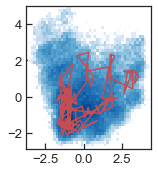

In [85]:
fig, ax = plt.subplots(1,1, figsize=(2.3,2.5))
ax.hist2d(tr.features[:,0], tr.features[:,1], \
                 bins=[50, 50], cmap='Blues', norm=mpl.colors.LogNorm())
plt.plot(tr.features[:500:5,0], tr.features[:500:5,1], '-', color='r')
plt.tight_layout()

In [31]:
DISC.kmeans(k=50, dim=10)

In [86]:
DISC = traj.Discretizer(tr)

In [87]:
DISC.hdbscan(mcs=100, ms=100, dim=4)

In [88]:
DISC.hdb_clusters

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

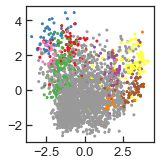

In [89]:
fig, ax = plt.subplots(1,1, figsize=(2.3,2.5))
ax.scatter(tr.features[:-1:20,0], tr.features[:-1:20,1], \
           c=tr.distraj[:-1:20], s=4, cmap='Set1')

In [61]:
from mastermsm.msm import msm

In [90]:
tr.find_keys()
msm_ala5 = msm.SuperMSM([tr])


 Building MSM from 
 ['test/data/ala5.xtc']
     # states: 10


In [91]:
for i in [10, 20, 50, 100, 200, 500, 1000, 2000, 5000]:
    msm_ala5.do_msm(i)
    msm_ala5.msms[i].do_trans()
    msm_ala5.msms[i].boots()

/Users/daviddesancho/Research/code/MasterMSM/mastermsm/msm/msm_lib.py:532: RuntimeWarning: invalid value encountered in log
  tauT.append(-lagt/np.log(lamT))
/Users/daviddesancho/Research/code/MasterMSM/mastermsm/msm/msm_lib.py:532: RuntimeWarning: invalid value encountered in log
  tauT.append(-lagt/np.log(lamT))
/Users/daviddesancho/Research/code/MasterMSM/mastermsm/msm/msm_lib.py:532: RuntimeWarning: invalid value encountered in log
  tauT.append(-lagt/np.log(lamT))
/Users/daviddesancho/Research/code/MasterMSM/mastermsm/msm/msm_lib.py:532: RuntimeWarning: invalid value encountered in log
  tauT.append(-lagt/np.log(lamT))
/Users/daviddesancho/Research/code/MasterMSM/mastermsm/msm/msm_lib.py:532: RuntimeWarning: invalid value encountered in log
  tauT.append(-lagt/np.log(lamT))
/Users/daviddesancho/Research/code/MasterMSM/mastermsm/msm/msm_lib.py:532: RuntimeWarning: invalid value encountered in log
  tauT.append(-lagt/np.log(lamT))
/Users/daviddesancho/Research/code/MasterMSM/masterm

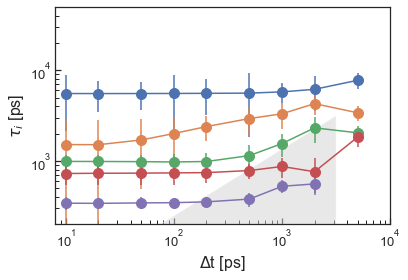

In [92]:
fig, ax = plt.subplots()
for i in range(5):
    tau_vs_lagt = np.array([[x,msm_ala5.msms[x].tauT[i], \
                         msm_ala5.msms[x].tau_std[i]] \
               for x in sorted(msm_ala5.msms.keys())])
    ax.errorbar(tau_vs_lagt[:,0],tau_vs_lagt[:,1],fmt='o-',\
            yerr=tau_vs_lagt[:,2], markersize=10)
ax.fill_between(np.logspace(0.1,3.5,10), np.logspace(1, 3.5, 10),\
                facecolor='lightgray', alpha=0.5)

ax.set_xlabel(r'$\Delta$t [ps]', fontsize=16)
ax.set_ylabel(r'$\tau_i$ [ps]', fontsize=16)
ax.set_ylim(200,50000)
ax.set_xlim(8,10**4)
ax.set_yscale('log')
_ = ax.set_xscale('log')

We resort to a built in method in the ```TimeSeries``` class for discretizing peptides based on torsion angles. Given the low population in the left-handed helix, we will simply use to states (A and E, for alpha and extended, respectively).

In [59]:
# Now clustering

In [48]:
tr.discretize(states=['A', 'E'])

AttributeError: 'TimeSeries' object has no attribute 'discretize'

Now we check whether the discretization has captured the relevant dynamics at the single amino acid level. We look into residue 2, which remains fairly helical during the simulation timescale, and residue 8, which fluctuates a lot.

Text(0.5, 0, 'Time [ps]')

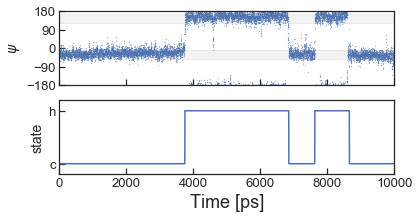

In [9]:
i = 2
y = [0 if x[i] == 'A' else 1 for x in tr.distraj]

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(6,3))
ax1.plot(psi[1][:,i]*180/np.pi,'o', markersize=0.2)
ax2.plot(y)
ax1.set_xlim(0,5000)
ax1.set_ylim(-180,180)
ax1.yaxis.set_ticks(range(-180,181,90))
ax1.set_ylabel(r'$\psi$', fontsize=14)

ax2.set_ylabel(r'state', fontsize=14)
ax2.set_xlim(0,10000)
ax2.set_ylim(-0.2,1.2)
ax2.yaxis.set_ticks([0,1])
labels = [item.get_text() for item in ax2.get_xticklabels()]
labels[0] = 'c'
labels[1] = 'h'
ax2.set_yticklabels(labels)
ax1.fill_between([0, 10000], -10, -50, alpha=0.1, color='gray')
ax1.fill_between([0, 10000], 165, 125, alpha=0.1, color='gray')

ax2.set_xlabel('Time [ps]')
ax2.set_xlabel(r'Time [ps]', fontsize=18)


Then we use the ```find_keys``` method from the ```TimeSeries``` objects to find the discrete states in the trajectory. Also, we sort the state names for convenience.

In [10]:
tr.find_keys()
tr.keys.sort()
tr.keys.reverse()
print ([x for x in tr.keys])

['EEEEE', 'EEEEA', 'EEEAE', 'EEEAA', 'EEAEE', 'EEAEA', 'EEAAE', 'EEAAA', 'EAEEE', 'EAEEA', 'EAEAE', 'EAEAA', 'EAAEE', 'EAAEA', 'EAAAE', 'EAAAA', 'AEEEE', 'AEEEA', 'AEEAE', 'AEEAA', 'AEAEE', 'AEAEA', 'AEAAE', 'AEAAA', 'AAEEE', 'AAEEA', 'AAEAE', 'AAEAA', 'AAAEE', 'AAAEA', 'AAAAE', 'AAAAA']


### Master equation model
Having discretized the trajectory onto 32 microstates, we can use it to construct the dynamical model using the ```msm``` module. In particular, the ```SuperMSM``` class helps coordinate the construction of many MSMs.

In [11]:
from mastermsm.msm import msm
msm_ala5 = msm.SuperMSM([tr])


 Building MSM from 
 [['data/ala5_amber03star_tip3p_tip3p_protein.xtc']]
     # states: 32


First of all, we carry out the most standard test for lifetime convergence, so that we learn which lag time is adequeate for recovering meaningful results.

In [17]:
msm_ala5.convergence_test(time=[1, 3, 10, 30, 100, 300], error=True)

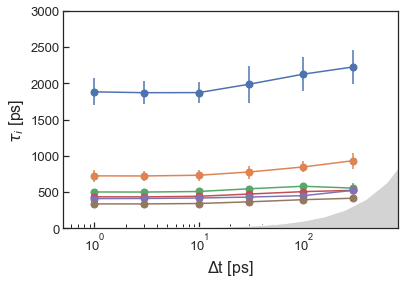

In [18]:
fig, ax = plt.subplots()
for i in range(6):
    tau_vs_lagt = np.array([[x,msm_ala5.msms[x].tauT[i],msm_ala5.msms[x].tau_std[i]] \
               for x in sorted(msm_ala5.msms.keys())])
    ax.errorbar(tau_vs_lagt[:,0],tau_vs_lagt[:,1],fmt='o-', yerr=tau_vs_lagt[:,2], markersize=7)
#ax.plot(tau_vs_lagt[:,0],tau_vs_lagt[:,0])
ax.fill_between(10**np.arange(-0.2,4,0.2), 1e-1, 10**np.arange(-0.2,4,0.2), facecolor='lightgray')
ax.set_xlabel(r'$\Delta$t [ps]', fontsize=16)
ax.set_ylabel(r'$\tau_i$ [ps]', fontsize=16)
ax.set_xlim(0.5,800)
ax.set_ylim(0,3e3)
_ = ax.set_xscale('log')
#_ = ax.set_yscale('log')

It seems that from very early on, the relaxation times of the model are pretty well converged.

### Analysis of the results
After chosing a lag time of 10 ps, we take a closer look at the eigenvalue spectrum.

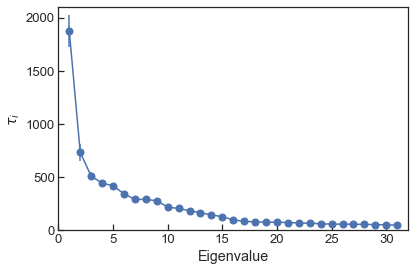

In [19]:
fig, ax = plt.subplots()
ax.errorbar(range(1,len(msm_ala5.msms[lagt].tauT)+1),msm_ala5.msms[lagt].tauT, fmt='o-', \
            yerr= msm_ala5.msms[lagt].tau_std, ms=7)
ax.set_xlabel('Eigenvalue')
ax.set_ylabel(r'$\tau_i$')
ax.set_ylim(0, 2100)
ax.set_xlim(0, 32)
plt.tight_layout()

Clearly there is a gap between the slowest relaxation time and the next one. We can take a look at the eigenvectors to recover information about the equilibrium distribution and the dynamical process associated with the slowest mode. The first right eigenvector provides information about the equilibrium distribution, which we can recover with proper normalization in the ```peqT``` attribute of the ```MSM``` object. The second left eigenvector, corresponding to the first non-zero eigenvalue, shows which state equilibrate at the corresponding relaxation time.

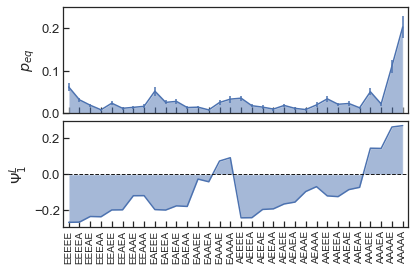

In [20]:
fig, ax = plt.subplots(2,1, sharex=True)
ax[0].errorbar(range(len(msm_ala5.msms[lagt].peqT)), msm_ala5.msms[lagt].peqT, \
               msm_ala5.msms[lagt].peq_std, fmt='-')
ax[0].fill_between(range(len(msm_ala5.msms[lagt].peqT)), \
                   msm_ala5.msms[lagt].peqT, 0, alpha=0.5)
ax[0].set_ylim(0,0.25)

ax[1].plot(msm_ala5.msms[lagt].lvecsT[:,1])
ax[1].axhline(0,0,25, c='k', ls='--', lw=1)
ax[1].fill_between(range(len(msm_ala5.msms[lagt].lvecsT[:,1])), \
                   msm_ala5.msms[lagt].lvecsT[:,1], 0, alpha=0.5)
ax[1].set_xlim(-0.5,31.5)
ax[1].set_xticks(range(0,32))
ax[1].set_xticklabels(msm_ala5.keys, rotation='vertical', fontsize=10)

ax[0].set_ylabel("$p_{eq}$")
ax[1].set_ylabel("$\Psi^L_1$")
plt.tight_layout(h_pad=0)

The results are interesting. The equilibrium distribution shows that the ```AAAAA``` microstate is the most stable for this particular force field. as it shows how helical states (all those containing an alpha-helix nucleus of ```AAA``` starting at positions 1 or 2) exchange with the states richer in extended conformation (i.e. having more ```E``` residues).

We can additionally estimate the rate matrix using the LB method and the approximate method that relies on a Taylor expansion using the following lines of code.

In [21]:
msm_ala5.do_lbrate()
msm_ala5.msms[lagt].do_rate()

Comparing the eigenvalue spectrum we find that in this case, all three estimates agree very well.

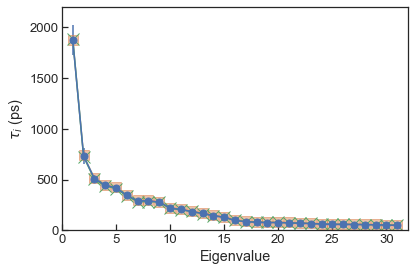

In [27]:
fig, ax = plt.subplots()
ax.errorbar(range(1,len(msm_ala5.msms[lagt].tauT)+1),msm_ala5.msms[lagt].tauT, fmt='o-', \
            yerr= msm_ala5.msms[lagt].tau_std, ms=7)
ax.plot(range(1,len(msm_ala5.keys)), msm_ala5.msms[lagt].tauK, 's-', markersize=10, alpha=0.5)
ax.plot(range(1,len(msm_ala5.keys)), msm_ala5.tauK, 'x-', markersize=12)
ax.set_xlabel('Eigenvalue')
ax.set_ylabel(r'$\tau_i$ (ps)')
ax.set_ylim(0, 2200)
ax.set_xlim(0, 32)
plt.tight_layout()

### Committors and fluxes
We can derive the value of the committor and the reactive flux if we are able to define two end states for the transition of interest. In this case, we choose the most and the least folded states.

In [24]:
msm_ala5.msms[lagt].do_pfold(UU="EEEEE", FF="AAAAA")

   definitely FF and UU states [0, 31]


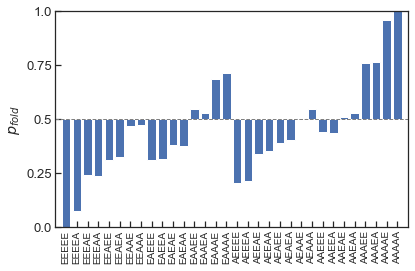

In [25]:
fig, ax = plt.subplots()
ax.bar(range(len(msm_ala5.keys)), msm_ala5.msms[lagt].pfold-0.5)
ax.set_xticks(range(0,32))
ax.set_xticklabels(msm_ala5.keys, rotation='vertical', fontsize=10)
ax.set_ylabel(r'$p_{fold}$')
ax.set_yticks(np.arange(-0.5,0.6,0.25))
ax.set_yticklabels(np.arange(0.,1.1,0.25))
ax.set_ylim(-0.5, 0.5)
ax.set_xlim(-1, 32)
ax.axhline(0, ls='--', color='gray', lw=1)
plt.tight_layout()

### Coarse graining of the network
The gap we found in the eigenvalue spectrum allows partitioning the system into sets of microstates that will equilibrate slowly. We can use the sign structure of the eigenvectors to define coarse grained states. This is implemented in the ```fewsm``` module. In this case, we choose to separate into two our MSM.

In [28]:
from mastermsm.fewsm import fewsm

In [32]:
fewsm_ala5 = fewsm.FEWSM(msm_ala5.msms[lagt], N=2)


 Initial membership of microstates to macrostates:
0 ['EAAAE', 'EAAAA', 'AAAEE', 'AAAEA', 'AAAAE', 'AAAAA']
1 ['EEEEE', 'EEEEA', 'EEEAE', 'EEEAA', 'EEAEE', 'EEAEA', 'EEAAE', 'EEAAA', 'EAEEE', 'EAEEA', 'EAEAE', 'EAEAA', 'EAAEE', 'EAAEA', 'AEEEE', 'AEEEA', 'AEEAE', 'AEEAA', 'AEAEE', 'AEAEA', 'AEAAE', 'AEAAA', 'AAEEE', 'AAEEA', 'AAEAE', 'AAEAA']


In [33]:
fewsm_ala5.map_trajectory()


 Mapping trajectory onto macrostates...


We will check our trajectory, mapped onto two coarse grained states, with the global helicity of the peptide conformations.

In [34]:
def fhelix(s):
    """
    Calculates the fraction helix of the pentapeptide from 
    the number of consecutive helical residues.
    
    Parameters
    ----------
    s : str
        String with assignment to helical (A) and extended (E)
        states.
        
    Returns
    -------
        float
        Value for the fraction helix.

    """
    if s == 'AAAAA':
        return 1
    elif 'AAAA' in s:
        return 0.8
    elif 'AAA' in s:
        return 0.6
    else:
        return 0.

Below we compare the discrete state trajectory with the fraction helix and the coarse-grained trajectory. Clearly, the coarse-grained model captures most of the global helix formation events in the simulation data.

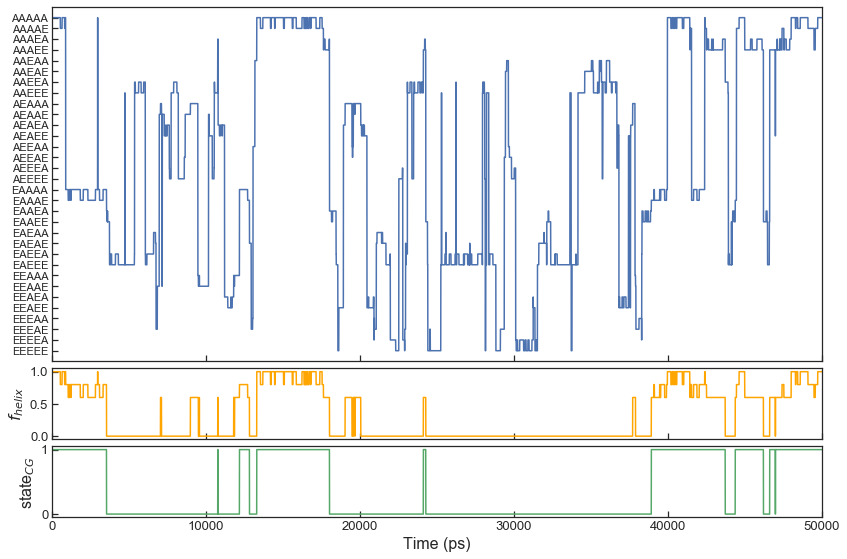

In [38]:
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(3,1, figure=fig, height_ratios=[5, 1, 1])

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1], sharex=ax0)
ax2 = fig.add_subplot(gs[2], sharex=ax0)

plt.setp(ax0.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)

ax0.plot([msm_ala5.keys.index(s) for s in tr.distraj], lw=1.5)

ax1.plot([fhelix(s) for s in tr.distraj], 'orange', lw=1.5)

ax2.plot([1 - x for x in fewsm_ala5.mappedtraj[0].distraj], 'g', lw=1.5)
ax0.set_yticks(range(0,32))
ax0.set_yticklabels(msm_ala5.keys, fontsize=11)
ax0.set_ylim(-1,32)

ax1.set_yticks(np.arange(0,1.1,0.5))
ax1.set_ylabel(r'$f_{helix}$', fontsize=16)

ax2.set_yticks([0,1])
ax2.set_ylabel('state$_{CG}$', fontsize=16)

ax2.set_xlabel('Time (ps)', fontsize=16)

ax0.set_xlim(0, 50000)

plt.tight_layout(h_pad=0)